# mHealth 데이터셋 탐색 및 딥러닝 설계
이 노트북은 mHealth 다중 센서 활동 인식 데이터셋을 분석하고, 윈도우 기반 딥러닝 분류기의 학습 파이프라인을 설계하기 위한 템플릿입니다. 각 셀을 순서대로 실행하면서 데이터 확인 → 전처리 → 학습 준비 → 모델 구성 단계로 진행하세요.

## 개요
- 센서 구성: 가슴(가속도+ECG), 왼발목(가속도/자이로/자기장), 오른팔(가속도/자이로/자기장) 총 23개 채널과 라벨 1~12(활동), 0(무동)
- 샘플링 주기: 50 Hz, 피험자별 파일 `mHealth_subject*.log` 로 제공
- 목표: 2~5초 윈도우로 분할한 뒤 활동 분류 모델(CNN+RNN/TCN 등) 학습

In [42]:
import json
from collections import Counter
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

try:
    from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
except ImportError:
    ConfusionMatrixDisplay = classification_report = confusion_matrix = None
    print('⚠️ scikit-learn이 설치되어 있지 않으면 혼동 행렬과 리포트가 생성되지 않습니다.')


In [43]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


In [44]:
DATA_DIR = Path.cwd() / "MHEALTHDATASET"

COLUMN_NAMES = [
    "acc_chest_x", "acc_chest_y", "acc_chest_z",
    "ecg_1", "ecg_2",
    "acc_ankle_x", "acc_ankle_y", "acc_ankle_z",
    "gyro_ankle_x", "gyro_ankle_y", "gyro_ankle_z",
    "mag_ankle_x", "mag_ankle_y", "mag_ankle_z",
    "acc_wrist_x", "acc_wrist_y", "acc_wrist_z",
    "gyro_wrist_x", "gyro_wrist_y", "gyro_wrist_z",
    "mag_wrist_x", "mag_wrist_y", "mag_wrist_z",
    "label",
]

FEATURE_COLUMNS = COLUMN_NAMES[:-1]

ACTIVITY_MAP = {
    1: "Standing still",
    2: "Sitting and relaxing",
    3: "Lying down",
    4: "Walking",
    5: "Climbing stairs",
    6: "Waist bends forward",
    7: "Frontal arms elevation",
    8: "Knees bending (crouch)",
    9: "Cycling",
    10: "Jogging",
    11: "Running",
    12: "Jump front & back",
}

SAMPLING_RATE_HZ = 50

subject_files = sorted(DATA_DIR.glob("mHealth_subject*.log"))

if not subject_files:
    raise FileNotFoundError(f"데이터 파일을 찾을 수 없습니다: {DATA_DIR}")

print(f"피험자 파일 수: {len(subject_files)}")
print(subject_files[:3])

피험자 파일 수: 10
[WindowsPath('c:/Users/이예일/OneDrive/바탕 화면/대학/3학년2학기/기학프/MHEALTHDATASET/mHealth_subject1.log'), WindowsPath('c:/Users/이예일/OneDrive/바탕 화면/대학/3학년2학기/기학프/MHEALTHDATASET/mHealth_subject10.log'), WindowsPath('c:/Users/이예일/OneDrive/바탕 화면/대학/3학년2학기/기학프/MHEALTHDATASET/mHealth_subject2.log')]


## 1. 라벨 분포 및 기본 통계
아래 셀은 피험자별 라벨 분포와 전체 데이터 크기를 스트리밍 방식으로 계산합니다. 메모리 사용을 줄이기 위해 `chunksize` 를 조정할 수 있습니다.

In [45]:
def summarize_labels(files: Iterable[Path], chunksize: int = 200_000) -> Tuple[Dict[str, Dict[int, int]], Dict[int, int]]:
    per_subject: Dict[str, Dict[int, int]] = {}
    total_counter: Counter = Counter()
    for path in files:
        counter = Counter()
        for chunk in pd.read_csv(
            path,
            sep="	",
            header=None,
            usecols=[23],
            names=["label"],
            chunksize=chunksize,
        ):
            chunk_counts = Counter(chunk["label"].astype(int))
            counter.update(chunk_counts)
            total_counter.update(chunk_counts)
        per_subject[path.name] = dict(sorted(counter.items()))
    return per_subject, dict(sorted(total_counter.items()))

per_subject_counts, total_counts = summarize_labels(subject_files)

summary_rows = []
labels_sorted = sorted({label for counts in per_subject_counts.values() for label in counts.keys()})
for name, counts in per_subject_counts.items():
    row = {"subject": name, "samples": sum(counts.values())}
    for label in labels_sorted:
        row[f"L{label:02d}"] = counts.get(label, 0)
    summary_rows.append(row)

label_summary_df = pd.DataFrame(summary_rows).set_index("subject")
display(label_summary_df)

print("총 샘플 수:", sum(total_counts.values()))
print("라벨별 총합:", total_counts)

,samples,L00,L01,L02,L03,L04,L05,L06,L07,L08,L09,L10,L11,L12
subject,,,,,,,,,,,,,,
mHealth_subject1.log,161280,126106,3072,3072,3072,3072,3072,3072,3072,3379,3072,3072,3072,1075
mHealth_subject10.log,98304,64614,3072,3072,3072,3072,3072,2458,2765,2867,3072,3072,3072,1024
mHealth_subject2.log,130561,95029,3072,3072,3072,3072,3072,3174,3328,3430,3072,3072,3072,1024
mHealth_subject3.log,122112,86732,3072,3072,3072,3072,3072,3226,3379,3175,3072,3072,3072,1024
mHealth_subject4.log,116736,81408,3072,3072,3072,3072,3072,3328,3277,3123,3072,3072,3072,1024
mHealth_subject5.log,119808,85861,3072,3072,3072,3072,3072,2765,2868,2714,3072,3072,3072,1024
mHealth_subject6.log,98304,66099,3072,3072,3072,3072,3072,2202,2099,2304,3072,3072,3072,1024
mHealth_subject7.log,104448,70195,3072,3072,3072,3072,3072,3072,2765,2816,3072,3072,3072,1024
mHealth_subject8.log,129024,95692,3072,3072,3072,3072,3072,2151,3021,2560,3072,3072,3072,1024


총 샘플 수: 1215745
라벨별 총합: {0: 872550, 1: 30720, 2: 30720, 3: 30720, 4: 30720, 5: 30720, 6: 28315, 7: 29441, 8: 29337, 9: 30720, 10: 30720, 11: 30720, 12: 10342}


### 라벨 불균형 처리 메모
- 라벨 0(전환/무동)이 매우 많으므로 학습 시 다운샘플링 또는 가중치 부여를 고려하세요.
- 라벨 12 데이터가 가장 적어 데이터 증강 또는 Focal Loss 같은 손실 함수를 검토하세요.

In [46]:
def compute_feature_stats(files: Iterable[Path], chunksize: int = 100_000) -> pd.DataFrame:
    min_vals = None
    max_vals = None
    sum_vals = None
    sumsq_vals = None
    count = 0

    for path in files:
        for chunk in pd.read_csv(
            path,
            sep="	",
            header=None,
            names=COLUMN_NAMES,
            usecols=range(len(COLUMN_NAMES)),
            chunksize=chunksize,
        ):
            data = chunk[FEATURE_COLUMNS].to_numpy(dtype=np.float64)
            if min_vals is None:
                min_vals = data.min(axis=0)
                max_vals = data.max(axis=0)
                sum_vals = data.sum(axis=0)
                sumsq_vals = np.square(data).sum(axis=0)
                count = data.shape[0]
            else:
                min_vals = np.minimum(min_vals, data.min(axis=0))
                max_vals = np.maximum(max_vals, data.max(axis=0))
                sum_vals += data.sum(axis=0)
                sumsq_vals += np.square(data).sum(axis=0)
                count += data.shape[0]

    mean_vals = sum_vals / count
    var_vals = np.maximum((sumsq_vals / count) - np.square(mean_vals), 0.0)
    std_vals = np.sqrt(var_vals)

    stats_df = pd.DataFrame({
        "min": min_vals,
        "max": max_vals,
        "mean": mean_vals,
        "std": std_vals,
    }, index=FEATURE_COLUMNS)

    return stats_df

feature_stats_df = compute_feature_stats(subject_files)
display(feature_stats_df.round(4))

normalization_stats = {
    "mean": feature_stats_df["mean"].to_numpy(),
    "std": feature_stats_df["std"].replace(0, 1e-6).to_numpy(),
}


,min,max,mean,std
acc_chest_x,-22.4380,19.0940,-8.5224,4.0753
acc_chest_y,-20.1880,20.9270,-0.2140,2.1390
acc_chest_z,-18.4010,26.1960,-1.0559,3.5742
ecg_1,-8.6196,8.5149,-0.0051,0.7466
ecg_2,-8.6196,8.5191,-0.0045,0.7270
acc_ankle_x,-22.1460,20.0540,1.4942,3.8265
acc_ankle_y,-19.6190,21.1610,-9.6929,4.1713
acc_ankle_z,-19.3730,25.0150,-0.9548,5.4618
gyro_ankle_x,-2.1466,60.4840,-0.0016,0.4912
gyro_ankle_y,-7.7899,2.0113,-0.6166,0.3546


### 정규화 권장 사항
- `normalization_stats` 사전을 활용하여 학습/검증 셋 모두 동일한 평균·표준편차로 z-score 정규화를 수행합니다.
- 센서별 단위 차이가 크므로 정규화 전후 히스토그램을 확인하면 좋습니다.

In [47]:
def majority_vote(labels: np.ndarray, ignore_zero: bool = False) -> int:
    if ignore_zero:
        labels = labels[labels != 0]
        if labels.size == 0:
            return 0
    values, counts = np.unique(labels, return_counts=True)
    return int(values[np.argmax(counts)])

def generate_windows(
    df: pd.DataFrame,
    window_size: int,
    step_size: int,
    include_null: bool = False,
    majority_ignore_zero: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:
    features = df[FEATURE_COLUMNS].to_numpy(dtype=np.float32)
    labels = df["label"].to_numpy(dtype=np.int64)

    windows: List[np.ndarray] = []
    window_labels: List[int] = []

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = features[start:end]
        label = majority_vote(labels[start:end], ignore_zero=majority_ignore_zero)
        if not include_null and label == 0:
            continue
        windows.append(window)
        window_labels.append(label)

    if not windows:
        return np.empty((0, window_size, len(FEATURE_COLUMNS)), dtype=np.float32), np.empty(0, dtype=np.int64)

    return np.stack(windows), np.array(window_labels, dtype=np.int64)

example_df = pd.read_csv(subject_files[0], sep="	", header=None, names=COLUMN_NAMES, nrows=10_000)
example_df["label"] = example_df["label"].astype(int)
example_windows, example_labels = generate_windows(example_df, window_size=250, step_size=125)
print(f"예시 윈도우 수: {len(example_windows)}, shape={example_windows.shape}")
print("라벨 분포:", Counter(example_labels))

예시 윈도우 수: 26, shape=(26, 250, 23)
라벨 분포: Counter({np.int64(1): 26})


### 윈도우 파라미터 선택 가이드
- 2초(100 프레임) 윈도우는 빠른 동작에 적합하고, 5초(250 프레임)는 컨텍스트 확보에 유리합니다.
- 보통 50% 겹침(step = window/2)으로 데이터 양과 시간 정보를 균형 있게 유지합니다.
- 활동 전환 구간을 잡고 싶다면 `include_null=True` 로 두고 후처리 시 smoothing 을 적용하세요.

In [48]:
class MHealthWindowDataset(Dataset):
    """mHealth 로그 파일을 윈도우 텐서로 변환하는 PyTorch Dataset"""

    def __init__(
        self,
        subjects: Iterable[int],
        data_dir: Path = DATA_DIR,
        window_size: int = 250,
        step_size: int = 125,
        include_null: bool = False,
        normalization: Optional[Dict[str, np.ndarray]] = None,
    ) -> None:
        self.subjects = list(subjects)
        self.data_dir = data_dir
        self.window_size = window_size
        self.step_size = step_size
        self.include_null = include_null
        self.normalization = normalization

        self.inputs: torch.Tensor
        self.targets: torch.Tensor
        self._prepare()

    def _load_subject(self, subject_id: int) -> pd.DataFrame:
        path = self.data_dir / f"mHealth_subject{subject_id}.log"
        if not path.exists():
            raise FileNotFoundError(path)
        df = pd.read_csv(path, sep="	", header=None, names=COLUMN_NAMES)
        df["label"] = df["label"].astype(int)

        features = df[FEATURE_COLUMNS].to_numpy(dtype=np.float32)
        if self.normalization is not None:
            mean = np.asarray(self.normalization["mean"], dtype=np.float32)
            std = np.asarray(self.normalization["std"], dtype=np.float32)
            features = (features - mean) / std
        df.loc[:, FEATURE_COLUMNS] = features
        return df

    def _prepare(self) -> None:
        window_tensors: List[torch.Tensor] = []
        label_tensors: List[torch.Tensor] = []

        for subject_id in self.subjects:
            df = self._load_subject(subject_id)
            windows, labels = generate_windows(
                df,
                window_size=self.window_size,
                step_size=self.step_size,
                include_null=self.include_null,
                majority_ignore_zero=not self.include_null,
            )
            if windows.size == 0:
                continue
            window_tensor = torch.from_numpy(windows).permute(0, 2, 1).contiguous()
            label_tensor = torch.from_numpy(labels)
            window_tensors.append(window_tensor)
            label_tensors.append(label_tensor)

        if window_tensors:
            self.inputs = torch.cat(window_tensors, dim=0)
            self.targets = torch.cat(label_tensors, dim=0)
        else:
            num_features = len(FEATURE_COLUMNS)
            self.inputs = torch.empty((0, num_features, self.window_size), dtype=torch.float32)
            self.targets = torch.empty((0,), dtype=torch.long)

    def __len__(self) -> int:
        return self.targets.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.inputs[idx], self.targets[idx]


### 데이터셋 분할 전략 메모
- Leave-One-Subject-Out (LOSO) 교차검증: 피험자 독립성을 보장하며 일반화 성능 평가에 가장 보수적입니다.
- 대안으로 8명 학습 / 1명 검증 / 1명 테스트 등 피험자 단위 홀드아웃을 구성할 수 있습니다.
- 학습/검증/테스트 라벨 분포를 사전에 확인하고 클래스 불균형이 심하면 가중치/리샘플링을 적용하세요.

In [49]:
class CNNBaseline(nn.Module):
    """1D CNN 기반 mHealth 활동 분류기"""

    def __init__(self, in_channels: int = len(FEATURE_COLUMNS), num_classes: int = len(ACTIVITY_MAP) + 1):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2, stride=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


model = CNNBaseline()
print(model)


CNNBaseline(
  (feature_extractor): Sequential(
    (0): Conv1d(23, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=128, out_features=13, bias=True)
  )
)


In [50]:
default_device = "cuda" if torch.cuda.is_available() else "cpu"


@dataclass
class TrainConfig:
    epochs: int = 30
    lr: float = 1e-3
    weight_decay: float = 1e-4
    grad_clip: Optional[float] = None
    device: str = default_device


def create_class_weights(labels: Iterable[int], ignore_zero: bool = False) -> torch.Tensor:
    counts = Counter(labels)
    if ignore_zero and 0 in counts:
        counts.pop(0)
    if not counts:
        return torch.ones(len(ACTIVITY_MAP) + 1, dtype=torch.float32)
    max_count = max(counts.values())
    weight_map = {label: max_count / count for label, count in counts.items()}
    weights = torch.ones(len(ACTIVITY_MAP) + 1, dtype=torch.float32)
    for label, weight in weight_map.items():
        weights[label] = weight
    return weights


def train_one_epoch(model: nn.Module, dataloader: DataLoader, criterion, optimizer, device: str, grad_clip: Optional[float] = None) -> Tuple[float, float]:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        running_loss += loss.item() * targets.size(0)
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    return running_loss / total, correct / total


def evaluate(model: nn.Module, dataloader: DataLoader, criterion, device: str) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * targets.size(0)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return running_loss / total, correct / total


def predict(model: nn.Module, dataloader: DataLoader, device: str) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    all_preds: List[np.ndarray] = []
    all_targets: List[np.ndarray] = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets.numpy())
    return np.concatenate(all_preds), np.concatenate(all_targets)


Train windows: 2410, Val: 296, Test: 292
[01] train_loss=1.7705 acc=0.673 | val_loss=1.2182 acc=0.851
[02] train_loss=0.6289 acc=0.932 | val_loss=0.2802 acc=0.909
[03] train_loss=0.1481 acc=0.989 | val_loss=0.0457 acc=1.000
[04] train_loss=0.0471 acc=0.993 | val_loss=0.0278 acc=1.000
[05] train_loss=0.0291 acc=0.995 | val_loss=0.0249 acc=1.000
[06] train_loss=0.0194 acc=0.997 | val_loss=0.0142 acc=1.000
[07] train_loss=0.0134 acc=0.997 | val_loss=0.0224 acc=1.000
[08] train_loss=0.0122 acc=0.996 | val_loss=0.0112 acc=1.000
[09] train_loss=0.0087 acc=0.999 | val_loss=0.0102 acc=1.000
[10] train_loss=0.0073 acc=0.999 | val_loss=0.0102 acc=1.000
[11] train_loss=0.0041 acc=1.000 | val_loss=0.0114 acc=1.000
[12] train_loss=0.0038 acc=1.000 | val_loss=0.0089 acc=1.000
[13] train_loss=0.0042 acc=0.999 | val_loss=0.0079 acc=1.000
[14] train_loss=0.0026 acc=1.000 | val_loss=0.0061 acc=1.000
[15] train_loss=0.0025 acc=1.000 | val_loss=0.0042 acc=1.000
[16] train_loss=0.0019 acc=1.000 | val_loss=

,epoch,train_loss,train_acc,val_loss,val_acc
0,1,1.770544,0.673444,1.218242,0.851351
1,2,0.628917,0.931535,0.280155,0.908784
2,3,0.148056,0.988797,0.045716,1.000000
3,4,0.047147,0.993361,0.027757,1.000000
4,5,0.029080,0.995436,0.024917,1.000000
5,6,0.019367,0.996680,0.014230,1.000000
6,7,0.013383,0.997095,0.022365,1.000000
7,8,0.012210,0.996266,0.011170,1.000000
8,9,0.008667,0.999170,0.010158,1.000000
9,10,0.007348,0.998755,0.010181,1.000000


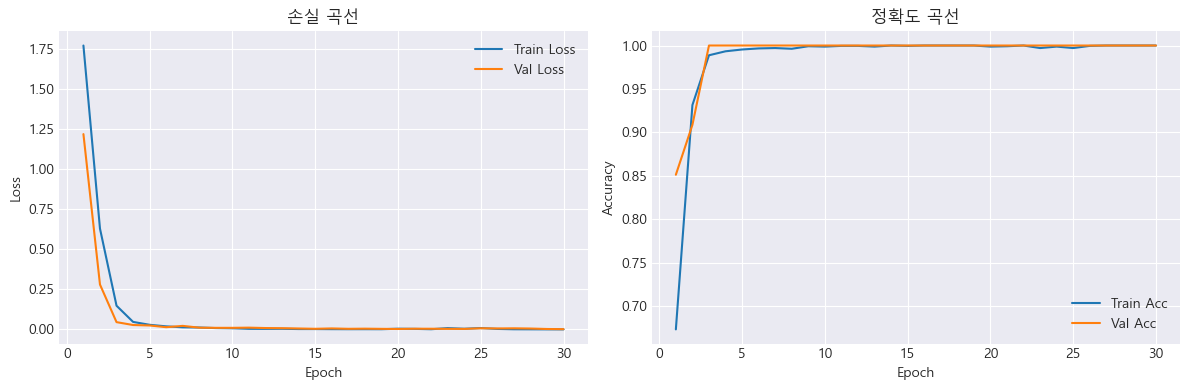

Test: loss=0.2715 acc=0.860


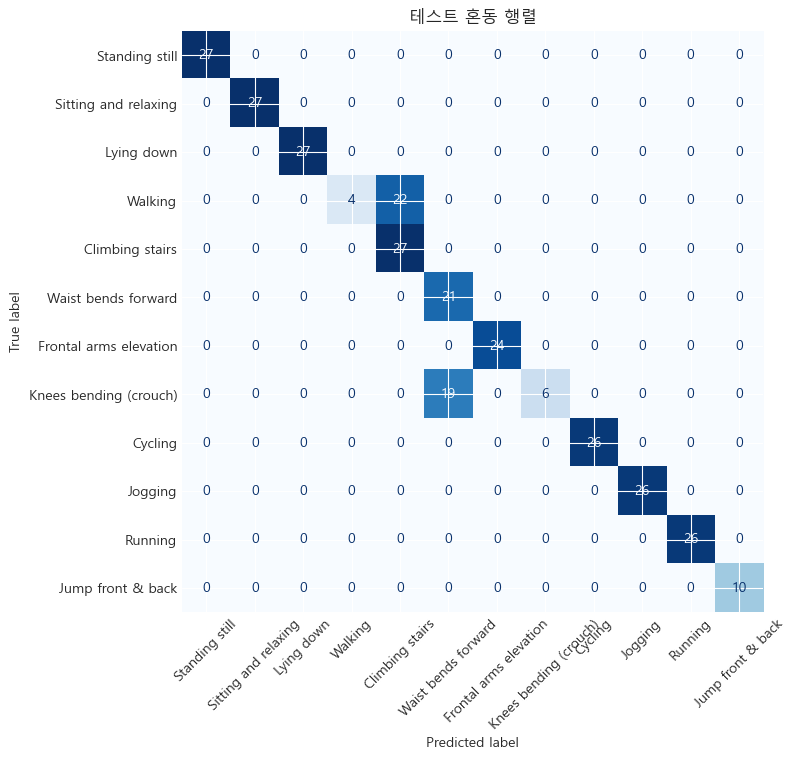

                        precision    recall  f1-score   support

        Standing still      1.000     1.000     1.000        27
  Sitting and relaxing      1.000     1.000     1.000        27
            Lying down      1.000     1.000     1.000        27
               Walking      1.000     0.154     0.267        26
       Climbing stairs      0.551     1.000     0.711        27
   Waist bends forward      0.525     1.000     0.689        21
Frontal arms elevation      1.000     1.000     1.000        24
Knees bending (crouch)      1.000     0.240     0.387        25
               Cycling      1.000     1.000     1.000        26
               Jogging      1.000     1.000     1.000        26
               Running      1.000     1.000     1.000        26
     Jump front & back      1.000     1.000     1.000        10

              accuracy                          0.860       292
             macro avg      0.923     0.866     0.838       292
          weighted avg      0.924     

In [51]:
train_subjects = [1, 2, 3, 4, 5, 6, 7, 8]
val_subjects = [9]
test_subjects = [10]

train_dataset = MHealthWindowDataset(train_subjects, window_size=250, step_size=125, normalization=normalization_stats)
val_dataset = MHealthWindowDataset(val_subjects, window_size=250, step_size=125, normalization=normalization_stats)
test_dataset = MHealthWindowDataset(test_subjects, window_size=250, step_size=125, normalization=normalization_stats)

print(f"Train windows: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

if len(train_dataset) == 0 or len(val_dataset) == 0:
    raise RuntimeError("윈도우가 생성되지 않았습니다. window_size와 step_size를 확인하세요.")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

config = TrainConfig()
device = config.device
model = CNNBaseline().to(device)

class_weights = create_class_weights(train_dataset.targets.tolist(), ignore_zero=False).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

history: List[Dict[str, float]] = []

for epoch in range(1, config.epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, grad_clip=config.grad_clip)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    history.append(
        {
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
        }
    )
    print(f"[{epoch:02d}] train_loss={train_loss:.4f} acc={train_acc:.3f} | val_loss={val_loss:.4f} acc={val_acc:.3f}")

history_df = pd.DataFrame(history)
display(history_df)

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams.update({
    "font.family": "Malgun Gothic", 
    "axes.unicode_minus": False, 
})
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_df["epoch"], history_df["train_loss"], label="Train Loss")
axes[0].plot(history_df["epoch"], history_df["val_loss"], label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_title("손실 곡선")

axes[1].plot(history_df["epoch"], history_df["train_acc"], label="Train Acc")
axes[1].plot(history_df["epoch"], history_df["val_acc"], label="Val Acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_title("정확도 곡선")
plt.tight_layout()
plt.show()

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test: loss={test_loss:.4f} acc={test_acc:.3f}")

preds, targets = predict(model, test_loader, device)

if confusion_matrix is not None:
    cm = confusion_matrix(targets, preds, labels=sorted(ACTIVITY_MAP.keys()))
    disp = ConfusionMatrixDisplay(cm, display_labels=[ACTIVITY_MAP[k] for k in sorted(ACTIVITY_MAP.keys())])
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
    ax.set_title("테스트 혼동 행렬")
    plt.tight_layout()
    plt.show()
else:
    print("scikit-learn이 없어 혼동 행렬을 생성하지 않습니다.")

if classification_report is not None:
    report = classification_report(
        targets,
        preds,
        labels=sorted(ACTIVITY_MAP.keys()),
        target_names=[ACTIVITY_MAP[k] for k in sorted(ACTIVITY_MAP.keys())],
        digits=3,
    )
    print(report)
else:
    print("scikit-learn이 없어 분류 리포트를 생성하지 않습니다.")


## 다음 단계 제안
- LOSO 교차검증 루프를 구현해 피험자 독립 일반화 성능을 측정하세요.
- 혼동 행렬, 매크로 F1/리콜 등 클래스 불균형에 민감한 지표를 시각화하세요.
- TCN, InceptionTime, Transformer 등 대안 아키텍처와 윈도우 크기/중첩 비율을 실험해 성능을 비교하세요.